# Import Packages & Dataset

In [1]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from shutil import copy
import random
import collections
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

C:\Users\liangnic\anaconda3\envs\Food_Classification\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# GPU Testing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
gpus = tf.config.list_physical_devices('GPU')
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


Use to check GPU Memory and rest the memory

In [17]:
from tensorflow.keras.backend import clear_session
clear_session()

In [18]:
!nvidia-smi

Thu Sep 21 13:54:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P8              15W / 310W |   7411MiB /  8192MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
print(os.getcwd())

C:\Users\liangnic\PycharmProjects\Food_Classification


In [32]:
# File Saving PATH
PATH = 'ResNet50.h5'

## Download Dataset

You don't have to run the following code if its already downloaded

In [26]:
def get_data():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir=None,
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted successfully!")

def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    #print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")


get_data()

print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

# Data Preprocessing

In [4]:
train_dir = 'food-101/train'
test_dir = 'food-101/test'
food_list = sorted(os.listdir('food-101/images'))

In [5]:
N_CLASS = 101
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 25

In [6]:
def dataset_preprocessing(train_dir, test_dir):

  train_datagen = ImageDataGenerator(
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          rescale=1. / 255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')

  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

  validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True)

  return train_generator, validation_generator

In [7]:
train_generator, validation_generator = dataset_preprocessing(train_dir, test_dir)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


# Model Training

## First download the pre-trained model

In [19]:
resnet50 = ResNet50(weights='imagenet', include_top=False)

In [20]:
model = Sequential()
model.add(resnet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(N_CLASS, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 101)               25957     
Total params: 24,139,237
Trainable params: 24,085,605
Non-trainable params: 53,632
_______________________________________

In [22]:
len(model.trainable_variables)

218

## Transfer Learning

The layer numbers:}
- layer3: 39:80
- layer4: 81:142
- layer5: 143:-1

In [37]:
class LearningRateTracker(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        _lr = backend.get_value(optimizer.lr)
        print(f'\nEpoch {epoch+1}: Learning rate is {_lr}.')

callbacks_list = [callbacks.ModelCheckpoint(
        filepath = "ResNet50_retrained",
        monitor = 'val_loss',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=2,
            mode='auto',
            min_delta=0.002,
            min_lr=1e-8),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=4, # we wait more in training section
            verbose=1,
            mode='auto',
            baseline=None),
        LearningRateTracker()]

In [13]:
# Code for drawing the output plot
def draw_plot(acc, val_acc, loss, val_loss):

  plt.figure(1, figsize = (15,8))

  plt.subplot(221)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'])

  plt.subplot(222)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'])

  plt.show()

### Unfreeze the Conv_4+5

In [23]:
resnet50.trainable = True
for layer in resnet50.layers[:81]: #unfreezed the last layer conv_4+5
  layer.trainable = False

In [24]:
# check whether we unfreezed the correct layers
print(len(model.trainable_variables))

for i, layer in enumerate(resnet50.layers) :
  print(i, layer.name,layer.trainable)

122
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_

In [26]:
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history_conv4 = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks = callbacks_list)

Epoch 1/25
1184/1184 [==============================] - 602s 506ms/step - loss: 3.4308 - accuracy: 0.1930 - val_loss: 3.1775 - val_accuracy: 0.2305

Epoch 1: Learning rate is 0.0100.
Epoch 2/25
1184/1184 [==============================] - 589s 497ms/step - loss: 3.4083 - accuracy: 0.1976 - val_loss: 3.4301 - val_accuracy: 0.1910

Epoch 2: Learning rate is 0.0100.
Epoch 3/25
1184/1184 [==============================] - 576s 487ms/step - loss: 3.4037 - accuracy: 0.1973 - val_loss: 3.4942 - val_accuracy: 0.1847

Epoch 3: Learning rate is 0.0010.
Epoch 4/25
1184/1184 [==============================] - 577s 487ms/step - loss: 3.3822 - accuracy: 0.2021 - val_loss: 3.1112 - val_accuracy: 0.2461

Epoch 4: Learning rate is 0.0010.
Epoch 5/25
1184/1184 [==============================] - 577s 488ms/step - loss: 3.3780 - accuracy: 0.2040 - val_loss: 3.1101 - val_accuracy: 0.2493

Epoch 5: Learning rate is 0.0010.
Epoch 6/25
1184/1184 [==============================] - 576s 486ms/step - loss: 3.373

let's get the output images

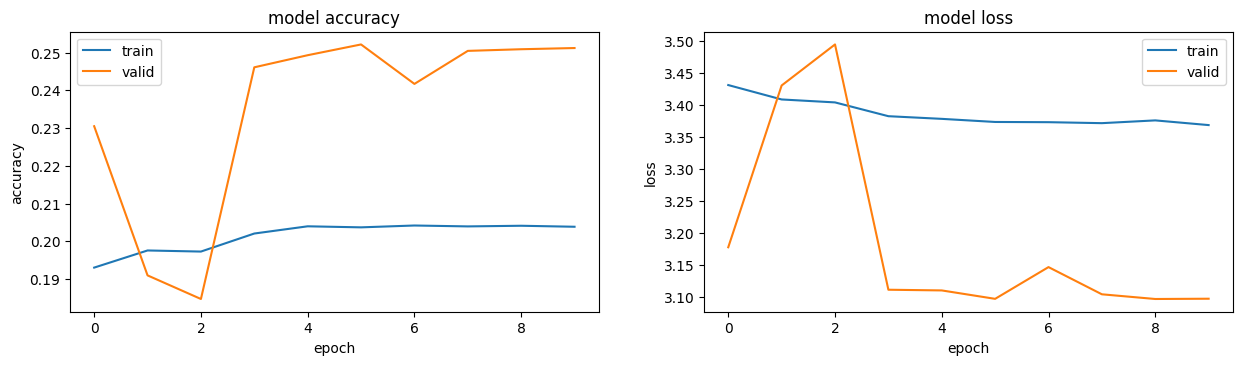

In [27]:
acc = history_conv4.history['accuracy']
val_acc = history_conv4.history['val_accuracy']
loss = history_conv4.history['loss']
val_loss = history_conv4.history['val_loss']

draw_plot(acc, val_acc, loss, val_loss)

In [28]:
resnet50.trainable = True
for layer in resnet50.layers[:39]: #unfreezed the last layer conv_3
  layer.trainable = False

In [29]:
print(len(model.trainable_variables))

for i, layer in enumerate(resnet50.layers) :
  print(i, layer.name,layer.trainable)

174
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_

In [31]:
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history_all = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    initial_epoch=history_conv4.epoch[-1],
                    verbose=1,
                    callbacks = callbacks_list)

Epoch 10/25
1184/1184 [==============================] - 599s 504ms/step - loss: 3.4347 - accuracy: 0.1931 - val_loss: 6.8237 - val_accuracy: 0.0147

Epoch 10: Learning rate is 0.0100.
Epoch 11/25
1184/1184 [==============================] - 576s 487ms/step - loss: 3.2766 - accuracy: 0.2208 - val_loss: 6.5604 - val_accuracy: 0.0296

Epoch 11: Learning rate is 0.0100.
Epoch 12/25
1184/1184 [==============================] - 590s 498ms/step - loss: 3.1897 - accuracy: 0.2343 - val_loss: 10.1713 - val_accuracy: 0.0079

Epoch 12: Learning rate is 0.0100.
Epoch 13/25
1184/1184 [==============================] - 589s 498ms/step - loss: 3.1380 - accuracy: 0.2440 - val_loss: 5.9905 - val_accuracy: 0.0147

Epoch 13: Learning rate is 0.0010.
Epoch 14/25
1184/1184 [==============================] - 575s 485ms/step - loss: 3.0102 - accuracy: 0.2695 - val_loss: 3.2747 - val_accuracy: 0.2216

Epoch 14: Learning rate is 0.0010.
Epoch 15/25
1184/1184 [==============================] - 574s 485ms/step -

C:\Users\liangnic\anaconda3\envs\Food_Classification\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



Epoch 17: Learning rate is 0.0001.
Epoch 18/25
1184/1184 [==============================] - 577s 487ms/step - loss: 2.9290 - accuracy: 0.2836 - val_loss: 2.6728 - val_accuracy: 0.3297

Epoch 18: Learning rate is 0.0001.
Epoch 19/25
1184/1184 [==============================] - 577s 487ms/step - loss: 2.9252 - accuracy: 0.2852 - val_loss: 2.6822 - val_accuracy: 0.3273

Epoch 19: Learning rate is 0.0001.
Epoch 20/25
1184/1184 [==============================] - 576s 486ms/step - loss: 2.9194 - accuracy: 0.2873 - val_loss: 2.6553 - val_accuracy: 0.3320

Epoch 20: Learning rate is 0.0001.
Epoch 21/25
1184/1184 [==============================] - 577s 487ms/step - loss: 2.9127 - accuracy: 0.2882 - val_loss: 2.6690 - val_accuracy: 0.3286

Epoch 21: Learning rate is 0.0001.
Epoch 22/25
1184/1184 [==============================] - 578s 488ms/step - loss: 2.9130 - accuracy: 0.2869 - val_loss: 2.6479 - val_accuracy: 0.3326

Epoch 22: Learning rate is 0.0000.
Epoch 23/25
1184/1184 [================

### Unfreeze all the layers, recompile with a larger learning rate

In [33]:
model = load_model(PATH)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 101)               25957     
Total params: 24,139,237
Trainable params: 24,085,605
Non-trainable params: 53,632
_______________________________________

In [14]:
model.layers[0].trainable = True

In [35]:
len(model.trainable_variables)

218

In [16]:
EPOCHS += 20

In [38]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history_all = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks = callbacks_list)

C:\Users\liangnic\anaconda3\envs\Food_Classification\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25


ResourceExhaustedError:  OOM when allocating tensor with shape[1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/resnet50/conv4_block5_3_bn/FusedBatchNormV3 (defined at \AppData\Local\Temp\ipykernel_14536\1428539651.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_213077]

Function call stack:
train_function


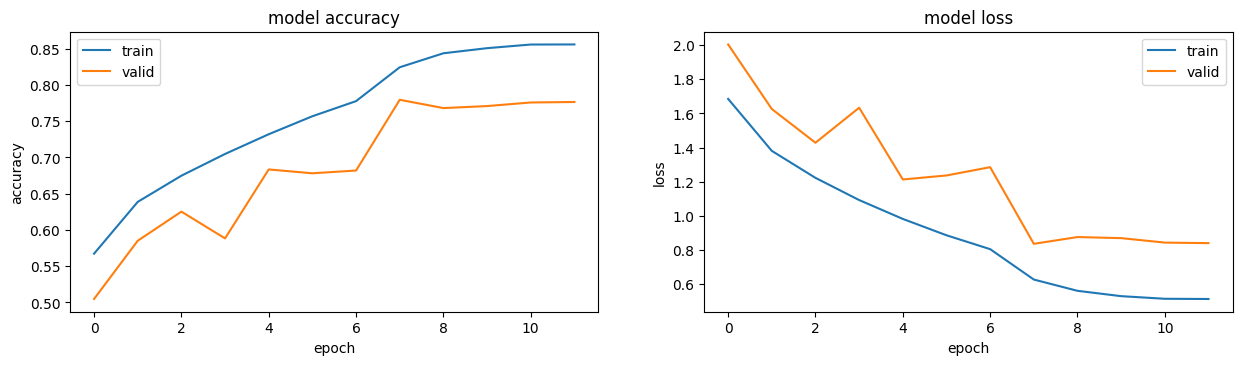

In [19]:
acc_all = history_all.history['accuracy']
val_acc_all = history_all.history['val_accuracy']
loss_all = history_all.history['loss']
val_loss_all = history_all.history['val_loss']

draw_plot(acc_all, val_acc_all, loss_all, val_loss_all)

# Performance